# Network Traffic Optimization

The following notebook demonstrates a solution to the network traffic optimization problem, applying the QAOA algorithm.

*Input:* Weighted directed graph and a set of demands.
*Goal:* Satisfy the demands  without violating the constraints.

In [1]:
import math
import random
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

from classiq import *
from classiq.execution import ExecutionPreferences, ExecutionSession

In [2]:
# Upload the latest version of Classiq
#!pip install -U classiq

## Create the graph and demands

In [3]:
V = ["A", "B", "C", "D", "E", "F"]
E_with_lat = [
    ("A", "B", 2),
    ("B", "E", 2),
    ("A", "C", 3),
    ("C", "E", 1),
    ("B", "D", 1),
    ("D", "F", 2),
    ("C", "D", 2),
    ("E", "F", 1),
]
E = [(u, v) for (u, v, _) in E_with_lat]
lat_vec = np.array([w for (_, _, w) in E_with_lat], dtype=float)
lat = {(u, v): w for (u, v, w) in E_with_lat}
edge_ids = [f"e{i+1}" for i in range(len(E))]
graph = nx.DiGraph()
graph.add_nodes_from(V)
graph.add_weighted_edges_from(E_with_lat)
E = graph.edges()
demands = [
    {"name": "d1", "s": "A", "t": "E"},
    {"name": "d2", "s": "B", "t": "F"},
    {"name": "d3", "s": "C", "t": "F"},
]
D = len(demands)
m = len(E)

## Solution

Z (2D) solution matrix — rows=demand, cols=edge
          e1  e2  e3  e4  e5  e6  e7  e8
d1(A→E)   1   0   1   0   0   0   0   0
d2(B→F)   0   0   0   1   0   0   1   0
d3(C→F)   0   0   0   0   1   0   0   1
Chosen edges & per-demand latency
      Demand Chosen edges  Latency sum
0  d1 (A→E)     A→B, B→E            4
1  d2 (B→F)     B→D, D→F            3
2  d3 (C→F)     C→E, E→F            2
Reconstructed s→t sequences (validity check)
      Demand Sequence  Is complete s→t?
0  d1 (A→E)    A→B→E              True
1  d2 (B→F)    B→D→F              True
2  d3 (C→F)    C→E→F              True


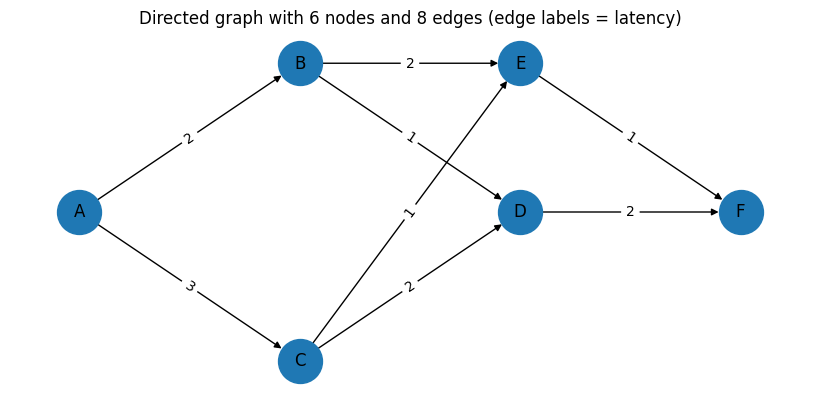

In [4]:
from scipy.optimize import Bounds, LinearConstraint, milp

Z = np.zeros((D, m))

# The mixer Hamiltonian is effectively X/2 and has eigenvalues -0.5 and +0.5. So the difference between minimum and maximum eigenvalues is exactly 1.
# This can be rescaled by a global scaling parameter.
GlobalScalingParameter = 1

# The constraint Hamiltonian has the property that a minimal constraint violation is 1 and no constraint violation is 0.
# We wish to normalise the constraint Hamiltonian relative to the total cost Hamiltonian such that the constraint violation will be 1~2 x larger than the maximal difference between total cost values.
RelativeConstraintNormalisation = 1

# The cost Hamiltonian should be similar in eigenvalue difference to the mixer Hamiltonian and should be normalised to about 1.
# To find the exact normalization requires solving this NP hard problem, so we always use an approximation.
# Since this is approximate, there is a relative scaling parameter we can tweak
RelativeCostNormalisation = 1 / 5

TotalCostNormalisation = GlobalScalingParameter * RelativeCostNormalisation
TotalConstraintNormalisation = RelativeConstraintNormalisation * TotalCostNormalisation

# Normalize latencies
min_solution_guess = (
    8  # can be calculated with Dijkstra when removing the single assignment constraint
)
max_solution_guess = 11  # any guess that fits the constraints will work

lat_normalized = {}
for e, w in lat.items():
    lat_normalized[e] = (
        w * TotalCostNormalisation / (max_solution_guess - min_solution_guess)
    )


c = np.tile(lat_vec, D)

# Variable bounds: 0 <= Z[d,e] <= 1 (binary)
lb = np.zeros(D * m)
ub = np.ones(D * m)
integrality = np.ones(D * m, dtype=int)


# Helper: map (d,e) -> flat index
def fidx(d_idx, e_idx):
    return d_idx * m + e_idx


lin_constraints = []

# (1) Capacity per edge (unit capacity): sum_d Z[d,e] <= 1
A_cap = np.zeros((m, D * m))
for e_idx in range(m):
    for d_idx in range(D):
        A_cap[e_idx, fidx(d_idx, e_idx)] = 1.0
cap_lb = -np.inf * np.ones(m)
cap_ub = np.ones(m)
lin_constraints.append(LinearConstraint(A_cap, cap_lb, cap_ub))


# (2) Flow conservation for each demand and node:
# For each demand d and node v: sum_out Z[d,e] - sum_in Z[d,e] = b_{d,v}
def incidence_row_for(d_idx, v):
    row = np.zeros(D * m)
    for e_idx, (u, v2) in enumerate(E):
        if u == v:  # outgoing
            row[fidx(d_idx, e_idx)] += 1.0
        if v2 == v:  # incoming
            row[fidx(d_idx, e_idx)] -= 1.0
    return row


A_flow_rows = []
b_list = []
for d_idx, d in enumerate(demands):
    for v in V:
        b = 0.0
        if v == d["s"]:
            b = 1.0
        elif v == d["t"]:
            b = -1.0
        A_flow_rows.append(incidence_row_for(d_idx, v))
        b_list.append(b)
A_flow = np.vstack(A_flow_rows)
b_vec = np.array(b_list)
lin_constraints.append(LinearConstraint(A_flow, b_vec, b_vec))

# ---------------------------
# Solve MILP
# ---------------------------
res = milp(
    c=c,
    integrality=integrality,
    bounds=Bounds(lb, ub),
    constraints=lin_constraints,
    options={"disp": False},
)

x = np.round(res.x).astype(int)

# Convert back to 2D Z[d,e]
Z = x.reshape(D, m)

# ---------------------------
# Decode / present results
# ---------------------------
# Table: Z with demand names and edge IDs
Z_df = pd.DataFrame(
    Z, index=[f"{d['name']}({d['s']}→{d['t']})" for d in demands], columns=edge_ids
)

# Table: chosen edges per demand + latency sums
rows = []
for d_idx, d in enumerate(demands):
    chosen_edges = [(u, v) for e_idx, (u, v) in enumerate(E) if Z[d_idx, e_idx] == 1]
    chosen_labels = [f"{u}→{v}" for (u, v) in chosen_edges]
    latency_sum = sum(lat[e] for e in chosen_edges)
    rows.append(
        {
            "Demand": f"{d['name']} ({d['s']}→{d['t']})",
            "Chosen edges": ", ".join(chosen_labels) if chosen_labels else "(none)",
            "Latency sum": latency_sum,
        }
    )
df_chosen = pd.DataFrame(rows)


# Try to reconstruct s→t sequence (simple walk)
def reconstruct_path(chosen_edges_list, s, t):
    nxt = {}
    for u, v in chosen_edges_list:
        nxt[u] = v
    path = [s]
    visited = set([s])
    while path[-1] != t and path[-1] in nxt:
        nxt_node = nxt[path[-1]]
        if nxt_node in visited:
            break
        path.append(nxt_node)
        visited.add(nxt_node)
    return path


seq_rows = []
for d_idx, d in enumerate(demands):
    chosen = [(u, v) for e_idx, (u, v) in enumerate(E) if Z[d_idx, e_idx] == 1]
    seq = reconstruct_path(chosen, d["s"], d["t"])
    seq_rows.append(
        {
            "Demand": f"{d['name']} ({d['s']}→{d['t']})",
            "Sequence": "→".join(seq),
            "Is complete s→t?": (
                len(seq) >= 2 and seq[0] == d["s"] and seq[-1] == d["t"]
            ),
        }
    )
df_sequences = pd.DataFrame(seq_rows)

# Objective value
objective = float(c @ x)

# Display
print("Z (2D) solution matrix — rows=demand, cols=edge\n", Z_df)
print("Chosen edges & per-demand latency\n", df_chosen)
print("Reconstructed s→t sequences (validity check)\n", df_sequences)

# ---------- 4) Visualize graph ----------
pos = {
    "A": (0, 0.6),
    "B": (1, 1.1),
    "C": (1, 0.1),
    "D": (2, 0.6),
    "E": (2, 1.1),
    "F": (3, 0.6),
}
plt.figure(figsize=(8, 3.6))
nx.draw(graph, pos, with_labels=True, node_size=1000)
edge_labels = {(u, v): lat[(u, v)] for (u, v) in E}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.title("Directed graph with 6 nodes and 8 edges (edge labels = latency)")
# plt.tight_layout()
plt.show()

## Solution with Classiq by appling the QAOA algorithm

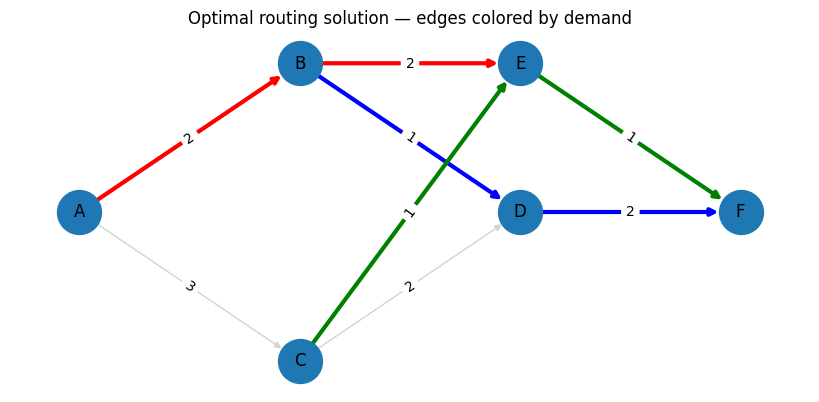

In [5]:
import matplotlib.pyplot as plt


def print_solution_graph(
    assigned_z, title="Optimal routing solution — edges colored by demand"
):
    # Assign a distinct color per demand
    colors_for_demands = ["red", "blue", "green"]
    edge_colors = []
    edge_widths = []

    # Build a mapping from edge -> demand index (if chosen)
    edge_to_demand = {}
    for d_idx, d in enumerate(demands):
        for e_idx, (u, v) in enumerate(graph.edges()):
            if assigned_z[d_idx, e_idx] == 1:
                edge_to_demand[(u, v)] = d_idx

    # Create color list for all edges in E
    for u, v in graph.edges():
        if (u, v) in edge_to_demand:
            demand_idx = edge_to_demand[(u, v)]
            edge_colors.append(colors_for_demands[demand_idx])
            edge_widths.append(3.0)
        else:
            edge_colors.append("lightgray")
            edge_widths.append(1.0)

    # Plot the graph
    pos = {
        "A": (0, 0.6),
        "B": (1, 1.1),
        "C": (1, 0.1),
        "D": (2, 0.6),
        "E": (2, 1.1),
        "F": (3, 0.6),
    }
    plt.figure(figsize=(8, 3.6))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=1000,
        edge_color=edge_colors,
        width=edge_widths,
    )
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels={(u, v): lat[(u, v)] for (u, v) in E}
    )
    plt.title(title)
    plt.show()


print_solution_graph(Z, "Optimal routing solution — edges colored by demand")

In [6]:
# Objective: sum_d sum_e lat_e * Z[d,e]


def objective_func(assigned_z):
    return sum(
        (lat_normalized[e] * assigned_z[fidx(d_idx, e_idx)])
        for d_idx, d in enumerate(demands)
        for e_idx, e in enumerate(graph.edges())
    )


def index_of_edge(u, v):
    for e_idx, edge in enumerate(graph.edges()):
        if edge[0] == u and edge[1] == v:
            return e_idx
    raise AssertionError("Edge not found")


def constraint_flow_conservation(assigned_z):
    total_flow = 0
    for d_idx, d in enumerate(demands):
        for v in V:
            out_sum = sum(
                assigned_z[fidx(d_idx, index_of_edge(v, v_out))]
                for v_out in graph.successors(v)
            )
            in_sum = sum(
                assigned_z[fidx(d_idx, index_of_edge(v_in, v))]
                for v_in in graph.predecessors(v)
            )
            source_correction = destination_correction = 0
            if d["s"] == v:
                source_correction = 1
            if d["t"] == v:
                destination_correction = 1
            node_demand_flow = (
                in_sum - out_sum + source_correction - destination_correction
            )
            total_flow += node_demand_flow**2
    return TotalConstraintNormalisation * total_flow


def constraint_single_assignment(assigned_z):

    def inverse(bit):
        return 1 - bit

    more_than_a_single_assignment = 0

    for e_idx, e in enumerate(graph.edges()):
        assignments_of_e = [
            assigned_z[fidx(d_idx, e_idx)] for d_idx, d in enumerate(demands)
        ]
        all_assignments = math.prod(assignments_of_e)
        two_assignments = 0
        for idx, current_assignment in enumerate(assignments_of_e):
            rest_of_assignments = [
                other_e
                for other_idx, other_e in enumerate(assignments_of_e)
                if idx != other_idx
            ]
            rest_of_assignments_off = math.prod(rest_of_assignments)
            two_assignments += inverse(current_assignment) * rest_of_assignments_off
        more_than_a_single_assignment += all_assignments + two_assignments
    return TotalConstraintNormalisation * more_than_a_single_assignment


# def constraint_single_assignment(assigned_z):
#     up_to_single_assignment = 0
#
#     for e_idx, e in enumerate(graph.edges()):
#         sum_across_demands = sum(assigned_z[fidx(d_idx, e_idx)] for d_idx, _ in enumerate(demands))
#         up_to_single_assignment += ((sum_across_demands - 0.5) / 1.5) ** 2
#     return up_to_single_assignment


def cost_hamiltonian(assigned_Z):
    objective_weight = 1
    flow_conservation_weight = 1
    single_assignment_weight = 1
    return (
        objective_weight * objective_func(assigned_Z)
        + flow_conservation_weight * constraint_flow_conservation(assigned_Z)
        + single_assignment_weight * constraint_single_assignment(assigned_Z)
    )

In [7]:
NUM_LAYERS = 5


@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(GlobalScalingParameter * beta, q), qba),


@qfunc
def main(
    params: CArray[CReal, 2 * NUM_LAYERS],
    z: Output[QArray[QBit, m * D]],
) -> None:
    allocate(z)
    hadamard_transform(z)

    repeat(
        count=NUM_LAYERS,
        iteration=lambda i: (
            phase(phase_expr=cost_hamiltonian(z), theta=params[2 * i]),
            mixer_layer(params[2 * i + 1], z),
        ),
    )

In [8]:
write_qmod(main, name="network_traffic_optimization", decimal_precision=15)
qprog = synthesize(main)

In [9]:
NUM_SHOTS = 10000
es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)


def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = math.pi * np.linspace(
        1 / (2 * NUM_LAYERS), 1 - 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )
    initial_betas = math.pi * np.linspace(
        1 - 1 / (2 * NUM_LAYERS), 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)


initial_params = initial_qaoa_params(NUM_LAYERS)

In [10]:
cost_func = lambda state: cost_hamiltonian(state["z"])
# estimate_cost_func = lambda params: es.estimate_cost(cost_func, {"params": params.tolist()})


def estimate_cost_func(params):
    objective_val = es.estimate_cost(cost_func, {"params": params.tolist()})
    objective_values.append(objective_val)
    # print(objective_val)
    return objective_val


# Record the steps of the optimization
intermediate_params = []
objective_values = []


# Define the callback function to store the intermediate steps
def callback(xk):
    intermediate_params.append(xk)
    objective_values.append(es.estimate_cost(cost_func, {"params": xk.tolist()}))

In [11]:
MAX_ITERATIONS = 10
with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    optimization_res = minimize(
        estimate_cost_func,
        x0=initial_params,
        method="COBYLA",
        # callback=callback,
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

Optimization Progress:   0%|                                                                                                            | 0/10 [00:00<?, ?it/s]/Users/roiedann/user-venv/lib/python3.11/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 12
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')
Optimization Progress:   0%|                                                                                                            | 0/10 [04:01<?, ?it/s]


Printing the optimized QAOA parameters

In [12]:
res = es.sample({"params": optimization_res.x.tolist()})
print(f"Optimized parameters: {optimization_res.x.tolist()}")

Optimized parameters: [0.3141592653589793, 2.827433388230814, 0.942477796076938, 2.199114857512855, 1.5707963267948966, 1.5707963267948966, 2.199114857512855, 0.9424777960769377, 2.827433388230814, 0.3141592653589793]


In [13]:
def check_validity(assigned_z: list[int]) -> bool:
    if constraint_flow_conservation(assigned_z) != 0:
        return False
    if constraint_single_assignment(assigned_z) != 0:
        return False
    return True

## Results

Print solutions, check their validity and signify the number of valid solution and thier associate index.

In [14]:
sorted_counts = sorted(res.parsed_counts, key=lambda pc: pc.shots, reverse=True)
count = 0


def print_res(sampled):
    color = "92m"
    assigned_z = sampled.state["z"]
    if not check_validity(assigned_z):
        color = "91m"
    print(
        f"\033[{color}solution={assigned_z} probability={sampled.shots/NUM_SHOTS} cost={cost_hamiltonian(assigned_z)}\033[0m, objective={objective_func(assigned_z)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)}"
    )


valid_solutions = []
for sampled in sorted_counts[:15]:
    print_res(sampled)
for idx, sampled in enumerate(sorted_counts):
    if check_validity(sampled.state["z"]):
        valid_solutions.append(idx)
        count += sampled.shots / NUM_SHOTS
        print(f"Valid solution at index {idx}")
print(count)

solution=[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1] probability=0.0048 cost=0.8, objective=5.999999999999999
solution=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1] probability=0.0047 cost=0.9333333333333333, objective=2.0
solution=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1] probability=0.0044 cost=0.7333333333333334, objective=5.0
solution=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1] probability=0.0038 cost=0.9333333333333333, objective=5.0
solution=[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1] probability=0.0033 cost=0.6, objective=8.999999999999998
solution=[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] probability=0.0032 cost=0.8666666666666667, objective=6.999999999999999
solution=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] probability=0.0032 cost=1.0, objective=3.0
solution=[0, 0, 0, 0, 0

Convert the 1D information to a 2D, suitable for plotting.

In [15]:
def convert_1d_to_2d(array_1d):
    array_2d = np.zeros((D, m))
    for d_idx in range(D):
        for e_idx in range(m):
            array_2d[d_idx][e_idx] = array_1d[fidx(d_idx, e_idx)]
    return array_2d


solution_0 = sorted_counts[2].state["z"]
print(convert_1d_to_2d(solution_0))
print(f"{check_validity(solution_0)=}")
print(f"{constraint_single_assignment(solution_0)=}")
print(f"{constraint_flow_conservation(solution_0)=}")
print(
    f"{objective_func(solution_0)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)=}"
)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1.]]
check_validity(solution_0)=False
constraint_single_assignment(solution_0)=0.0
constraint_flow_conservation(solution_0)=0.4
objective_func(solution_0)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)=5.0


Printing the valid solutions

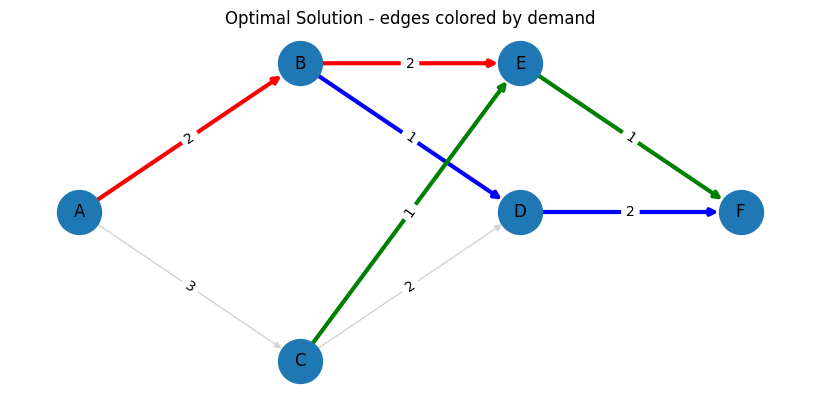

[[1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1.]]
check_validity(solution_i)=True
constraint_single_assignment(solution_i)=0.0
objective_func(solution_i)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)=8.999999999999998


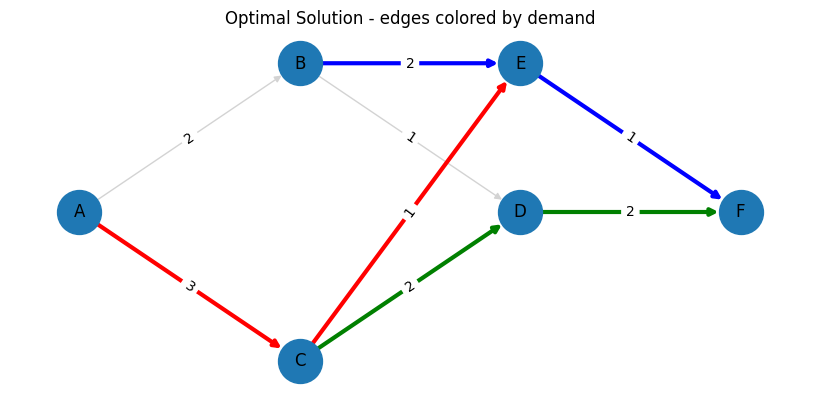

[[0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0.]]
check_validity(solution_i)=True
constraint_single_assignment(solution_i)=0.0
objective_func(solution_i)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)=10.999999999999998


In [16]:
for i in valid_solutions:
    solution_i = sorted_counts[i].state["z"]
    if i == 0:
        title = "Solution - edges colored by demand"
    else:
        title = "Optimal Solution - edges colored by demand"
    print_solution_graph(convert_1d_to_2d(solution_i), title)
    print(convert_1d_to_2d(solution_i))
    print(f"{check_validity(solution_i)=}")
    print(f"{constraint_single_assignment(solution_i)=}")
    print(
        f"{objective_func(solution_i)/TotalCostNormalisation * (max_solution_guess-min_solution_guess)=}"
    )